# Kaggle: house prices
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Import packages

In [233]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from scipy.stats.stats import skew
from scipy.stats.stats import pearsonr

## Import data

In [234]:
# Test and training set
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Combine into one dataset for the purposes of cleaning, and make sure that index continues
data_full = pd.concat([train, test], keys = ['train', 'test'])#ignore_index = True)

In [235]:
# What does the dataset look like?
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## Data cleansing

### Dealing with nulls

In [236]:
# Count the uniques for each column for a given dataframe
def df_uniques(df):
    print('Col name,', 'Number of nulls,', 'Number of unique values', '% of nulls')
    list_of_features = []
    for col in df:
        l = [col, df[col].shape[0] - df[col].count(), df[col].unique().shape[0], '%.3f' %((df[col].shape[0] - df[col].count()) / df[col].shape[0])]
        list_of_features.append(l)
    # Sort by the number of NULLs: 
    list_of_features = sorted(list_of_features, key = lambda x: x[1], reverse = True)
    return list_of_features

df_uniques(train)

Col name, Number of nulls, Number of unique values % of nulls


[['PoolQC', 1453, 4, '0.995'],
 ['MiscFeature', 1406, 5, '0.963'],
 ['Alley', 1369, 3, '0.938'],
 ['Fence', 1179, 5, '0.808'],
 ['FireplaceQu', 690, 6, '0.473'],
 ['LotFrontage', 259, 111, '0.177'],
 ['GarageType', 81, 7, '0.055'],
 ['GarageYrBlt', 81, 98, '0.055'],
 ['GarageFinish', 81, 4, '0.055'],
 ['GarageQual', 81, 6, '0.055'],
 ['GarageCond', 81, 6, '0.055'],
 ['BsmtExposure', 38, 5, '0.026'],
 ['BsmtFinType2', 38, 7, '0.026'],
 ['BsmtQual', 37, 5, '0.025'],
 ['BsmtCond', 37, 5, '0.025'],
 ['BsmtFinType1', 37, 7, '0.025'],
 ['MasVnrType', 8, 5, '0.005'],
 ['MasVnrArea', 8, 328, '0.005'],
 ['Electrical', 1, 6, '0.001'],
 ['Id', 0, 1460, '0.000'],
 ['MSSubClass', 0, 15, '0.000'],
 ['MSZoning', 0, 5, '0.000'],
 ['LotArea', 0, 1073, '0.000'],
 ['Street', 0, 2, '0.000'],
 ['LotShape', 0, 4, '0.000'],
 ['LandContour', 0, 4, '0.000'],
 ['Utilities', 0, 2, '0.000'],
 ['LotConfig', 0, 5, '0.000'],
 ['LandSlope', 0, 3, '0.000'],
 ['Neighborhood', 0, 25, '0.000'],
 ['Condition1', 0, 9, '0.0

In [237]:
# The following features have a crazy number of nulls 
# PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage 

# From looking at the data dictionary, these NAs are not necessarily a problem - but "NA" or nUll is misleading, so let's replace them
# Alley: NA = no alley -> replace with "None"
# MiscFeature: other features (e.g. tennis court) - NA = no other feature -> replace with "None"
# Fence: NA = no fence -> replace with "None"
# FireplaceQu: you guessed it -> replace with "None"

In [238]:
# Let's get a neat list of the null columns - need to combine both datasets for this
null_columns = [col for col in data_full.columns if data_full[col].isnull().any()]
print(null_columns)

['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities']


In [239]:
# Define a function to replace nulls for many columns: 
def fill_nulls(df, col_list, na_val):
    for col in col_list:
        df[col].fillna(value = na_val, inplace = True)
    return df

In [240]:
# Categorical fields with an obvious meaning NA -> 'None'
nulls_to_none = ['PoolQC', 'Fence', 'MiscFeature', 'Alley', 'FireplaceQu', 'MasVnrType', 'BsmtCond', 
                 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 
                 'GarageQual', 'GarageCond', 'KitchenQual']
# Numerical fields with an obvious meaning NA -> 0
nulls_to_zero = ['LotFrontage', 'MasVnrArea', 'BsmtQual', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 
                 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF']

# Categorical fields with a less obvious interpretation - guessing that NA means 'None' (there are very few anyway)
nulls_to_zero_2 = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd']
nulls_to_other = ['SaleType', 'Functional']

# Apply to both test and training sets:
for df in [train, test]: 
    fill_nulls(df, nulls_to_none, 'None')
    fill_nulls(df, nulls_to_zero, 0)
    fill_nulls(df, nulls_to_zero_2, 0)
    fill_nulls(df, nulls_to_other, 'Other')
# NB we still have 'data_full' which has not been updated yet

In [241]:
# Add more here about infilling with median values for some fields....

### Data types
Let's make sure everything is in the correct data type.  Pandas will have a go at importing things correctly, but this is good practice to make sure that things haven't gone awry. Ultimately we'll want to use dummy variables for categorical data anyway.

In [242]:
# Print out data types
def data_types(df):
    for col in df:
        print(col, type(df[col][1]))   

In [243]:
data_types(train)

Id <class 'numpy.int64'>
MSSubClass <class 'numpy.int64'>
MSZoning <class 'str'>
LotFrontage <class 'numpy.float64'>
LotArea <class 'numpy.int64'>
Street <class 'str'>
Alley <class 'str'>
LotShape <class 'str'>
LandContour <class 'str'>
Utilities <class 'str'>
LotConfig <class 'str'>
LandSlope <class 'str'>
Neighborhood <class 'str'>
Condition1 <class 'str'>
Condition2 <class 'str'>
BldgType <class 'str'>
HouseStyle <class 'str'>
OverallQual <class 'numpy.int64'>
OverallCond <class 'numpy.int64'>
YearBuilt <class 'numpy.int64'>
YearRemodAdd <class 'numpy.int64'>
RoofStyle <class 'str'>
RoofMatl <class 'str'>
Exterior1st <class 'str'>
Exterior2nd <class 'str'>
MasVnrType <class 'str'>
MasVnrArea <class 'numpy.float64'>
ExterQual <class 'str'>
ExterCond <class 'str'>
Foundation <class 'str'>
BsmtQual <class 'str'>
BsmtCond <class 'str'>
BsmtExposure <class 'str'>
BsmtFinType1 <class 'str'>
BsmtFinSF1 <class 'numpy.int64'>
BsmtFinType2 <class 'str'>
BsmtFinSF2 <class 'numpy.int64'>
BsmtUn

In [244]:
# By pasting the above list into a spreadsheet and cross checking with the data dictionary, we can 
# see which category each field should be

# statsmodel requires all fieldsnames to begin with letters, so let's sort this out now.
train = train.rename(columns = {'1stFlrSF': 'FirstFlrSF','2ndFlrSF': 'SecondFlrSF','3SsnPorch': 'ThreeSsnPorch'})
test = test.rename(columns = {'1stFlrSF': 'FirstFlrSF','2ndFlrSF': 'SecondFlrSF','3SsnPorch': 'ThreeSsnPorch'})
data_full = pd.concat([train, test], keys = ['train', 'test'])

# Makes lists of each type
categories = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
              'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 
              'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
              'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'Heating', 
              'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 
              'GarageFinish', 'GarageCars', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 
              'SaleCondition']
floats = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
          'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
          'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

ints = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
         'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']

bools = ['CentralAir']

# Define a function for converting a list of columns to a particular type: 
def convert_col_type(df, cols, type):
    for col in cols:
        df[col] = df[col].astype(type)

In [245]:
# Convert each column for both test and training sets:
for df in [train, test]:
    convert_col_type(df, categories, 'category')
    convert_col_type(df, floats, 'float')
    convert_col_type(df, ints, 'int')
    convert_col_type(df, bools, 'bool')
    
# Re-define the full dataset
data_full = pd.concat([train, test], keys = ['train', 'test'])

In [246]:
# Print out data types
def data_types(df):
    for col in df:
        print(col, type(df[col][1]))   
data_types(train)

Id <class 'numpy.int64'>
MSSubClass <class 'numpy.int64'>
MSZoning <class 'str'>
LotFrontage <class 'numpy.float64'>
LotArea <class 'numpy.float64'>
Street <class 'str'>
Alley <class 'str'>
LotShape <class 'str'>
LandContour <class 'str'>
Utilities <class 'str'>
LotConfig <class 'str'>
LandSlope <class 'str'>
Neighborhood <class 'str'>
Condition1 <class 'str'>
Condition2 <class 'str'>
BldgType <class 'str'>
HouseStyle <class 'str'>
OverallQual <class 'numpy.int64'>
OverallCond <class 'numpy.int64'>
YearBuilt <class 'numpy.int64'>
YearRemodAdd <class 'numpy.int64'>
RoofStyle <class 'str'>
RoofMatl <class 'str'>
Exterior1st <class 'str'>
Exterior2nd <class 'str'>
MasVnrType <class 'str'>
MasVnrArea <class 'numpy.float64'>
ExterQual <class 'str'>
ExterCond <class 'str'>
Foundation <class 'str'>
BsmtQual <class 'str'>
BsmtCond <class 'str'>
BsmtExposure <class 'str'>
BsmtFinType1 <class 'str'>
BsmtFinSF1 <class 'numpy.float64'>
BsmtFinType2 <class 'str'>
BsmtFinSF2 <class 'numpy.float64'>


## Motivating plots

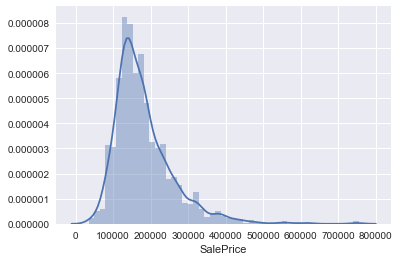

In [247]:
sales_price = train['SalePrice']
graph = sns.distplot(sales_price)

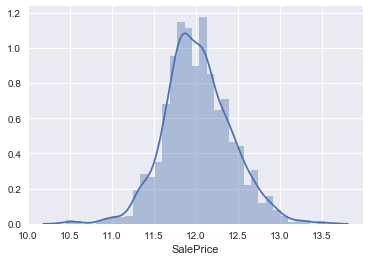

In [248]:
# Let's log-tranform this: 
sales_prices_log = np.log1p(sales_price)
graph = sns.distplot(sales_prices_log)

In [249]:
# Let's replace the SalePrice with the log-transformed version (will need to exponentiate predictions)
train['SalePrice'] = np.log1p(train['SalePrice'])

In [250]:
# Re-define the full dataset - and work on this until we are ready to split out test and train sets again
data_full = pd.concat([train, test], keys = ['train', 'test'])

In [251]:
# Let's see if any other features are skewed and replace these with log-transformed versions if so  
skewed_features = data_full[floats].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features

LotArea          12.822431
MasVnrArea        2.613592
BsmtFinSF1        1.425230
BsmtFinSF2        4.146143
BsmtUnfSF         0.919339
TotalBsmtSF       1.156894
FirstFlrSF        1.469604
SecondFlrSF       0.861675
LowQualFinSF     12.088761
GrLivArea         1.269358
WoodDeckSF        1.842433
OpenPorchSF       2.535114
EnclosedPorch     4.003891
ThreeSsnPorch    11.376065
ScreenPorch       3.946694
PoolArea         16.898328
MiscVal          21.947195
dtype: float64

In [252]:
skewed_features = skewed_features.index

In [253]:
#data_full[skewed_features] = np.log1p(data_full[skewed_features])
for col in skewed_features:
    print(col)
    data_full[col] = np.log1p(data_full[col])

LotArea
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
FirstFlrSF
SecondFlrSF
LowQualFinSF
GrLivArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
ThreeSsnPorch
ScreenPorch
PoolArea
MiscVal


In [255]:
data_full['MiscVal']

train  0       0.000000
       1       0.000000
       2       0.000000
       3       0.000000
       4       0.000000
       5       6.552508
       6       0.000000
       7       5.860786
       8       0.000000
       9       0.000000
       10      0.000000
       11      0.000000
       12      0.000000
       13      0.000000
       14      0.000000
       15      0.000000
       16      6.552508
       17      6.216606
       18      0.000000
       19      0.000000
       20      0.000000
       21      0.000000
       22      0.000000
       23      0.000000
       24      0.000000
       25      0.000000
       26      0.000000
       27      0.000000
       28      0.000000
       29      0.000000
                 ...   
test   1429    0.000000
       1430    0.000000
       1431    0.000000
       1432    0.000000
       1433    0.000000
       1434    0.000000
       1435    0.000000
       1436    0.000000
       1437    0.000000
       1438    0.000000
       1439    0

## Standardising numeric features

In [256]:
# Standardise numeric features (normalise)
numeric_features = data_full.loc[:,floats]
numeric_features_st = (numeric_features - numeric_features.mean())/numeric_features.std()

In [257]:
data_full.loc[:,floats] = numeric_features_st

In [258]:
ax = sns.pairplot(numeric_features_st)
# ax.savefig('charts_complete.png')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [259]:
# Too many variables!  

### Split test-train sets again

In [260]:
# First, create dummy variables for categorical variables
dummy = pd.get_dummies(train)
# split out the test and train sets again
train = data_full.ix['train']
test = data_full.ix['test']

## Linear regression, backward elimination

In [261]:
# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf

# create a fitted model with all three features
lm = smf.ols(formula='SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + FirstFlrSF + SecondFlrSF + LowQualFinSF + GrLivArea + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea + MiscVal + OverallQual + OverallCond + BsmtFullBath + BsmtHalfBath + FullBath + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + Fireplaces', data=train).fit()

# print the coefficients
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     317.8
Date:                Thu, 27 Apr 2017   Prob (F-statistic):               0.00
Time:                        15:26:30   Log-Likelihood:                 711.65
No. Observations:                1460   AIC:                            -1365.
Df Residuals:                    1431   BIC:                            -1212.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.1741      0.053    210.516      0.000      11.070      11.278
LotFrontage      -0.0055      0.004     -1.346      0.179      -0.014       0.003
LotArea           0.0407      0.005      8.332      0.000       0.031       0.050
MasVnrArea        0.0009      0.005      0.200      0.841      -0.008       0.010
BsmtFinSF1        0.0302      0.006      5.378      0.000       0.019       0.041
BsmtFinSF2       -0.0074      0.004     -1.657      0.098      -0.016       0.001
BsmtUnfSF        -0.0016      0.006     -0.262      0.793      -0.013       0.010
TotalBsmtSF       0.0141      0.006      2.291      0.022       0.002       0.026
FirstFlrSF       -0.0585      0.016     -3.697      0.000      -0.090      -0.027
SecondFlrSF      -0.0966      0.016     -6.126      0.000      -0.128      -0.066
LowQualFinSF     -0.0211      0.004     -5.446      0.000      -0.029      -0.013
GrLivArea         0.2034      0.020     10.206      0.000       0.164       0.242
GarageArea        0.0495      0.005      9.211      0.000       0.039       0.060
WoodDeckSF        0.0195      0.004      4.519      0.000       0.011       0.028
OpenPorchSF       0.0108      0.005      2.338      0.020       0.002       0.020
EnclosedPorch    -0.0193      0.004     -4.483      0.000      -0.028      -0.011
ThreeSsnPorch     0.0029      0.004      0.836      0.404      -0.004       0.010
ScreenPorch       0.0091      0.004      2.133      0.033       0.001       0.018
PoolArea         -0.0098      0.004     -2.585      0.010      -0.017      -0.002
MiscVal          -0.0083      0.004     -2.038      0.042      -0.016      -0.000
OverallQual       0.1089      0.005     22.781      0.000       0.100       0.118
OverallCond       0.0331      0.004      8.802      0.000       0.026       0.041
BsmtFullBath      0.0495      0.011      4.696      0.000       0.029       0.070
BsmtHalfBath      0.0104      0.018      0.593      0.553      -0.024       0.045
FullBath          0.0784      0.011      7.393      0.000       0.058       0.099
BedroomAbvGr     -0.0241      0.007     -3.309      0.001      -0.038      -0.010
KitchenAbvGr     -0.1377      0.021     -6.478      0.000      -0.179      -0.096
TotRmsAbvGrd      0.0082      0.005      1.591      0.112      -0.002       0.018
Fireplaces        0.0204      0.008      2.681      0.007       0.005       0.035
==============================================================================
Omnibus:                      669.449   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9437.068
Skew:                          -1.760   Prob(JB):                         0.00
Kurtosis:                      14.948   Cond. No.                         157.
================================================================

In [262]:
lm.pvalues.sort_values(ascending = False, inplace=False)

MasVnrArea       8.414271e-01
BsmtUnfSF        7.931320e-01
BsmtHalfBath     5.529802e-01
ThreeSsnPorch    4.035445e-01
LotFrontage      1.786190e-01
TotRmsAbvGrd     1.118334e-01
BsmtFinSF2       9.777473e-02
MiscVal          4.176936e-02
ScreenPorch      3.310422e-02
TotalBsmtSF      2.210066e-02
OpenPorchSF      1.952980e-02
PoolArea         9.842564e-03
Fireplaces       7.433182e-03
BedroomAbvGr     9.600875e-04
FirstFlrSF       2.260827e-04
EnclosedPorch    7.955633e-06
WoodDeckSF       6.709543e-06
BsmtFullBath     2.909035e-06
BsmtFinSF1       8.793188e-08
LowQualFinSF     6.050539e-08
SecondFlrSF      1.162495e-09
KitchenAbvGr     1.274979e-10
FullBath         2.424824e-13
LotArea          1.838430e-16
OverallCond      3.797195e-18
GarageArea       1.111225e-19
GrLivArea        1.175387e-23
OverallQual      2.842494e-98
Intercept        0.000000e+00
dtype: float64

In [263]:
# Best features
lm.pvalues.sort_values(ascending = False, inplace=False).head(10)

MasVnrArea       0.841427
BsmtUnfSF        0.793132
BsmtHalfBath     0.552980
ThreeSsnPorch    0.403544
LotFrontage      0.178619
TotRmsAbvGrd     0.111833
BsmtFinSF2       0.097775
MiscVal          0.041769
ScreenPorch      0.033104
TotalBsmtSF      0.022101
dtype: float64

In [264]:
# Worse features
lm.pvalues.sort_values(ascending = False, inplace=False).tail(10)

LowQualFinSF    6.050539e-08
SecondFlrSF     1.162495e-09
KitchenAbvGr    1.274979e-10
FullBath        2.424824e-13
LotArea         1.838430e-16
OverallCond     3.797195e-18
GarageArea      1.111225e-19
GrLivArea       1.175387e-23
OverallQual     2.842494e-98
Intercept       0.000000e+00
dtype: float64

## Collinearity
Let's check to see which predictors are correlated - many features are essentially the same thing.

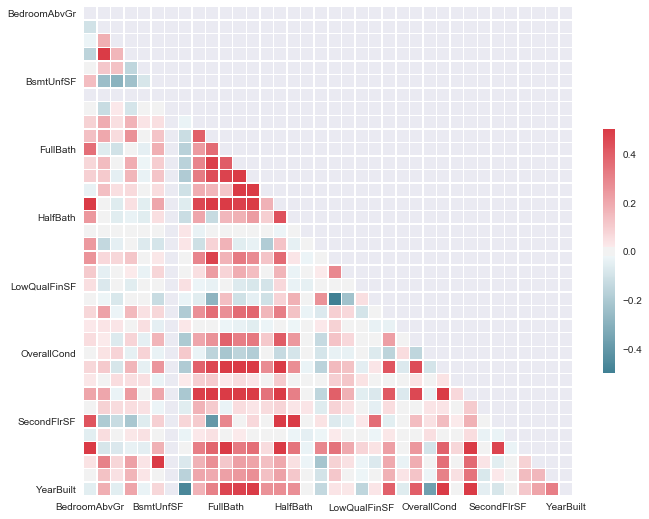

In [265]:
# Compute the correlation matrix
corr = data_full.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Simpler version (but too small to be useful)
# plt.matshow(data_full.corr())

Several predictors seem to be correlated, but the maximum correlation appears to be 0.4, so it's not worth removing these.

## Modelling: splitting the testing and training sets again

In [266]:
# Features - remove the thing we're trying to predict!
features = data_full.drop('SalePrice', axis = 1)

# Create dummy variables - for each categorical data, make several booleans
features = pd.get_dummies(features)

#creating matrices for sklearn:
X_train = features[:train.shape[0]]
X_test = features[train.shape[0]:]
y = train['SalePrice']

# Verify that the 
print(train.shape, X_train.shape)

(1460, 81) (1460, 385)


## Ridge regularisation (L2 regularisation)

In [267]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

In [268]:
# Define root-mean-square-error function - use 10-fold cross-validation
# You have to use neg_mean_squared_error because mean_squared_error will be deprecated in future
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

# Invoke Ridge regularisation
model_ridge = Ridge()

In [269]:
# Tune parameters - the only parameter is alpha - the larger alpha, the larger the penalty for extra predictors
alphas = [0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# Work out the RMSE for each value of the alphas above: 
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)

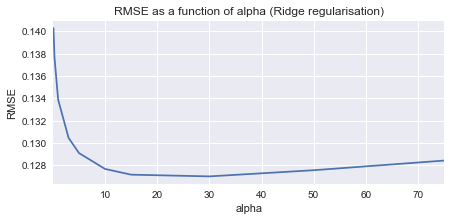

In [270]:
# Let's plot this
matplotlib.rcParams['figure.figsize'] = (7,3)
cv_ridge.plot(title = 'RMSE as a function of alpha (Ridge regularisation)')
plt.xlabel('alpha')
plt.ylabel('RMSE')

We want to chose the value of $\alpha$ that minimises the chart above. The extreme cases are $\alpha = 0$, which corresponds to no penalty for each extra predictor, and $\alpha\to\inf$ which corresponds to a null model.  We want a balance between flexibility and over-fitting, which represents the minimium of this chart.

In [271]:
cv_ridge.min()

0.12700475231309477

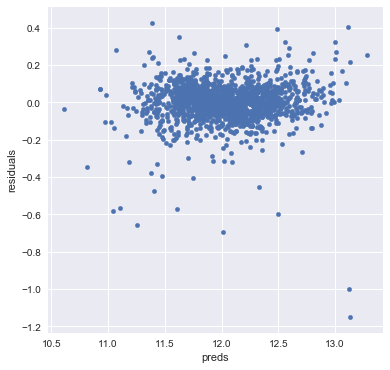

In [272]:
#let's look at the residuals as well:
model_ridge = Ridge(alpha = 30)
model_ridge.fit(X_train, y)

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_ridge.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## Lasso regularisation (L1 regularisation)
The advantage of Lasso regularisation is that it performs some feature selection

In [273]:
model_lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
                     max_iter = 50000, cv = 10).fit(X_train, y)
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

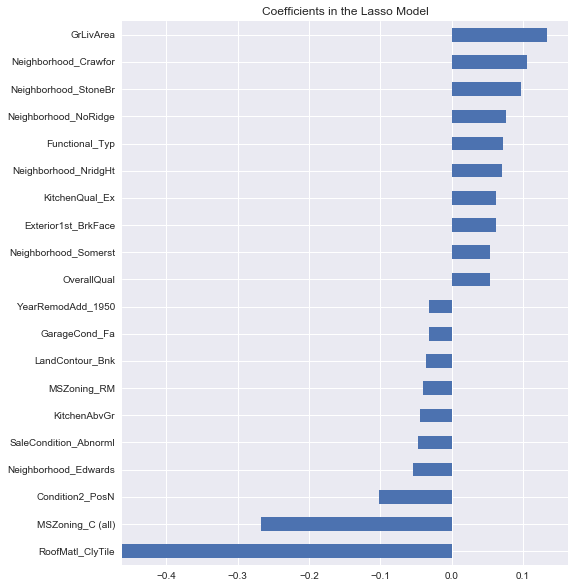

In [274]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# we need to bootstrap this and do it on a few random samples

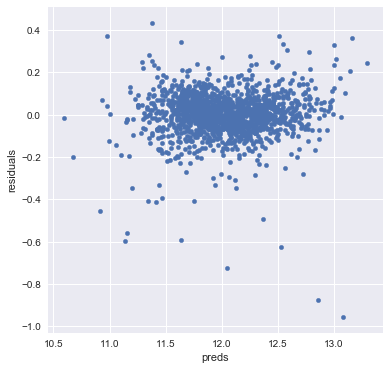

In [275]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

# Make predictions

In [276]:
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [278]:
kaggle_export = pd.DataFrame({
    'id': test['Id'],
    'SalePrice': lasso_preds
},
columns = ['id', 'SalePrice'])

In [293]:
# Export with timestamp in filename so we can save results from different runs
filebasename = 'kaggle_export'
stamp = datetime.today().strftime('%Y%m%d-%H%M%S')
filename = filebasename + stamp
kaggle_export.to_csv(filebasename, index = False)